Surface data file loaded: /Users/william/Desktop/Thesis-AES/Data/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt
Downhole data file loaded: /Users/william/Desktop/Thesis-AES/Data/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT
surface time min/max: (Timestamp('2023-12-10 14:42:58'), Timestamp('2023-12-10 17:33:17'))
downhole time min/max: (Timestamp('2023-12-09 21:24:09'), Timestamp('2023-12-11 01:33:42'))
Estimated delay: 1.03 h


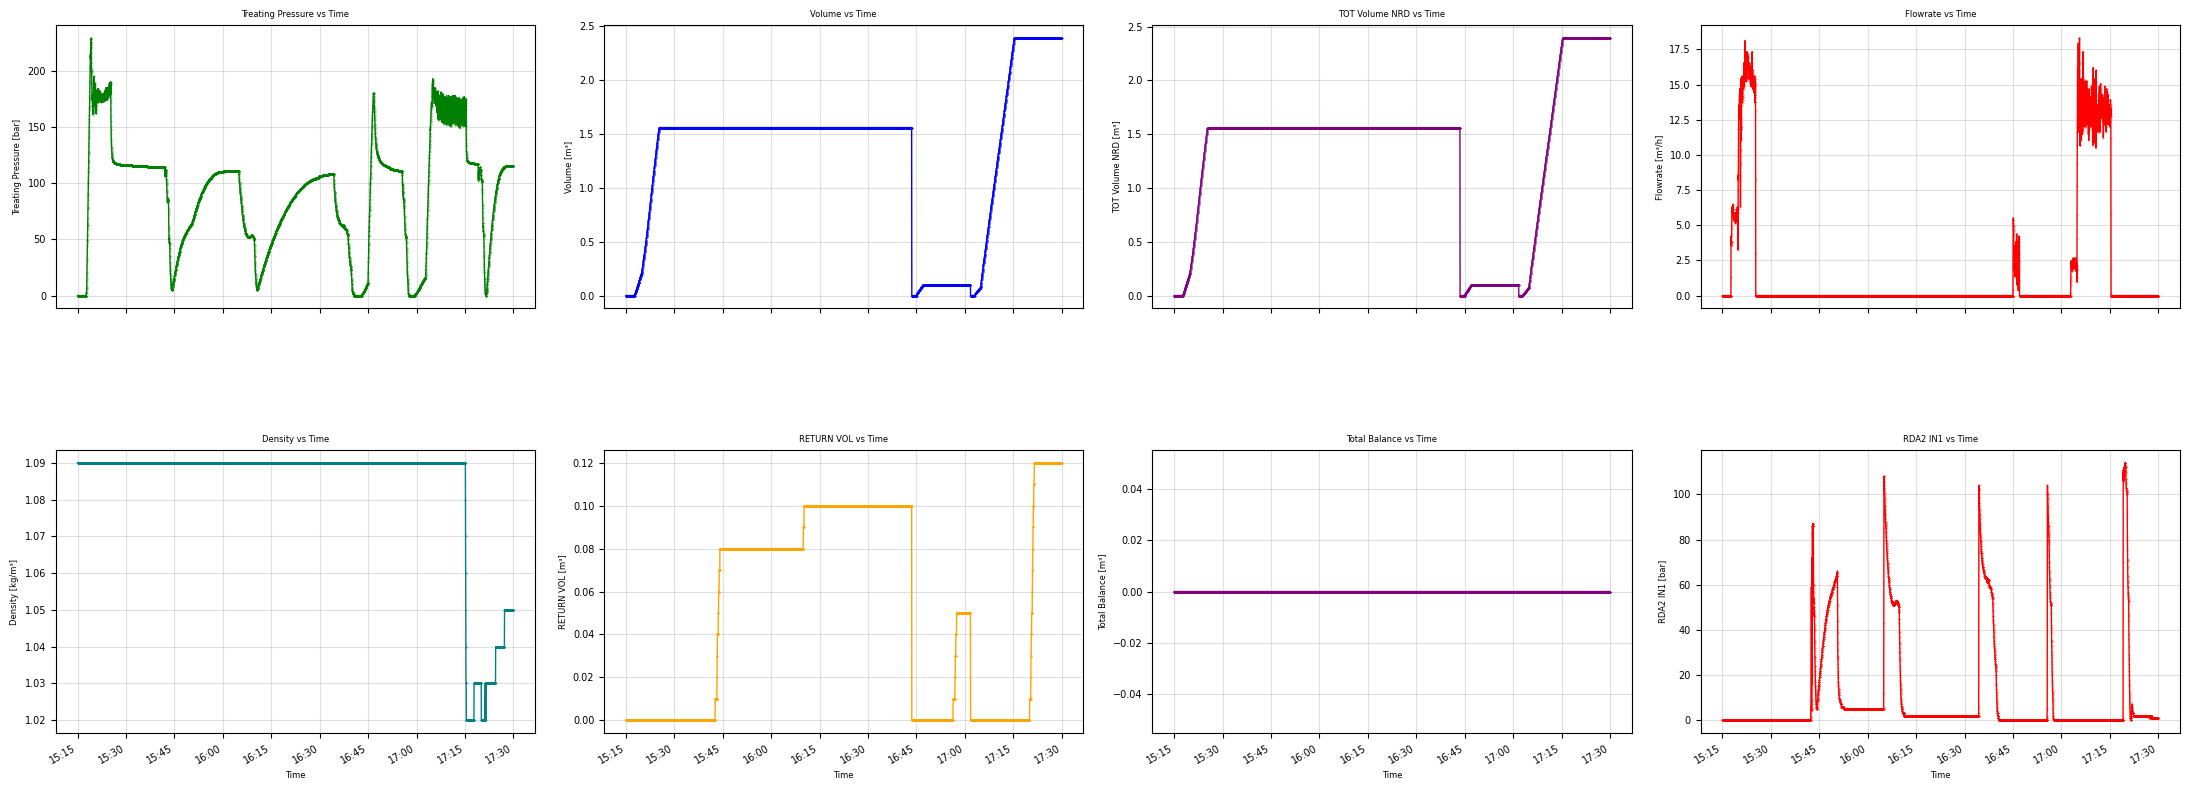

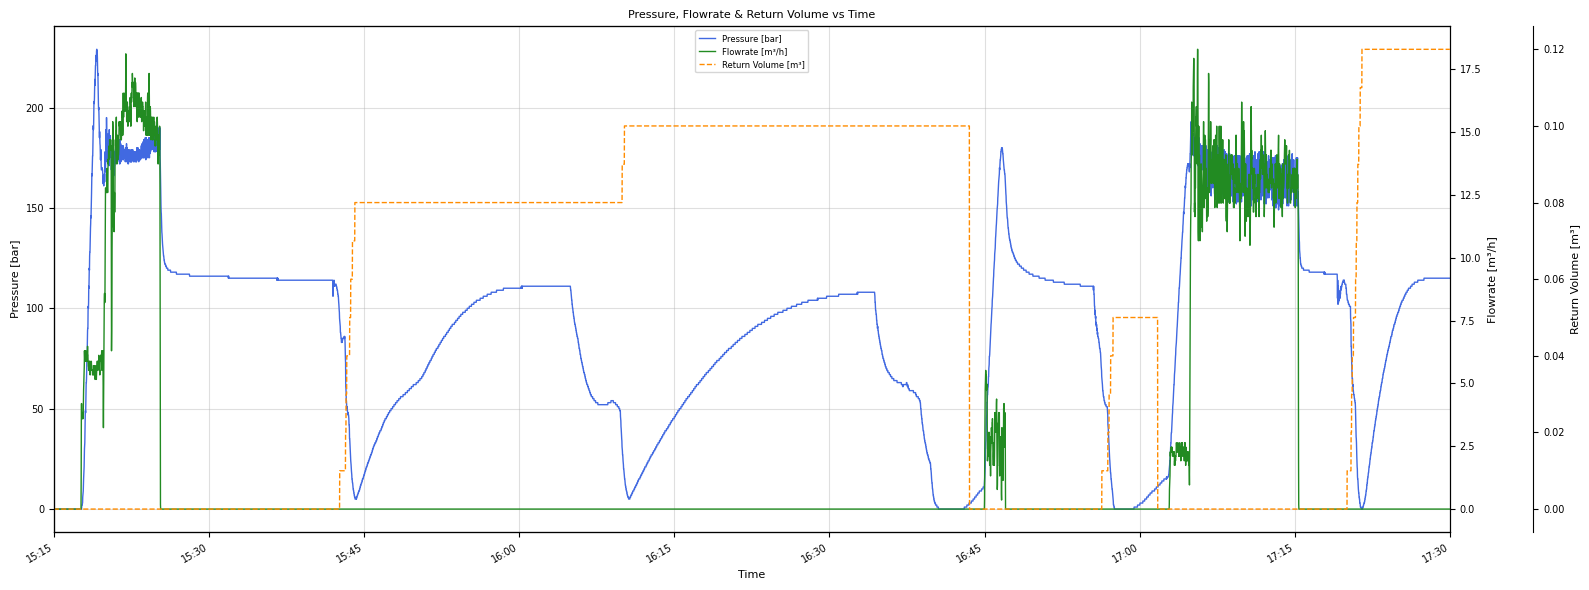

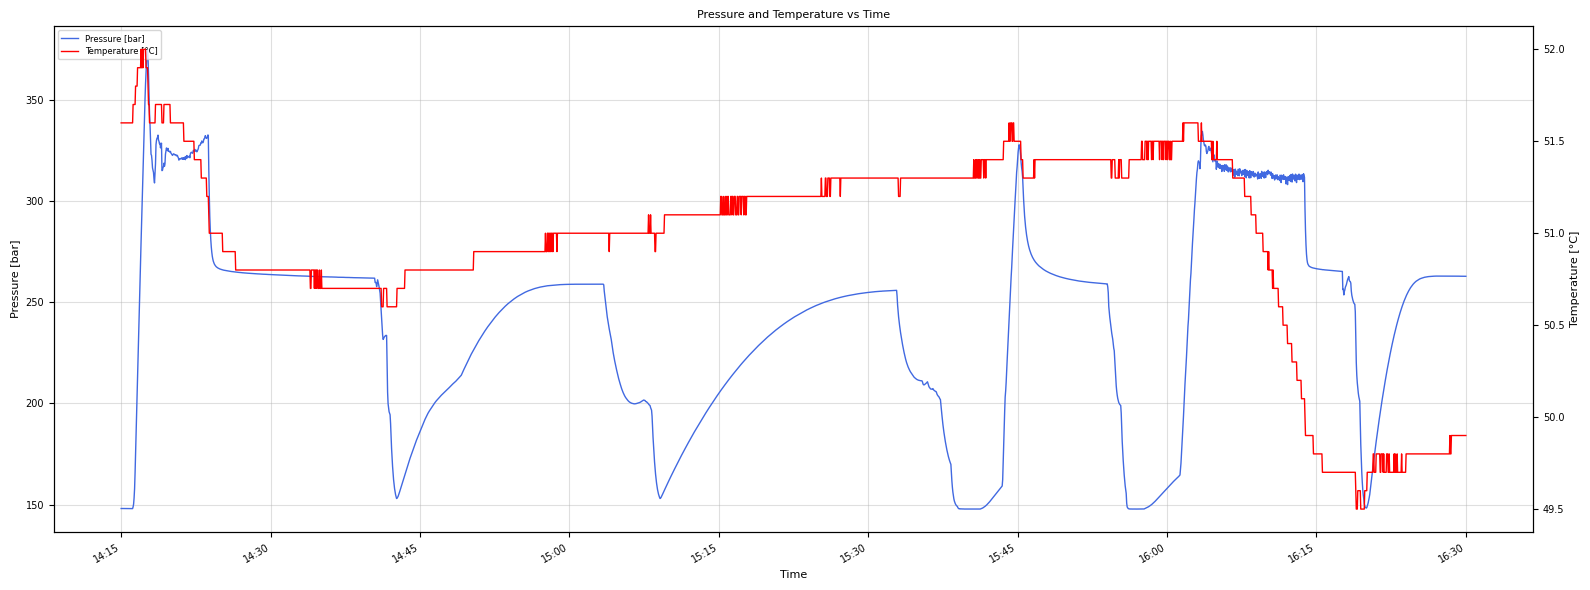

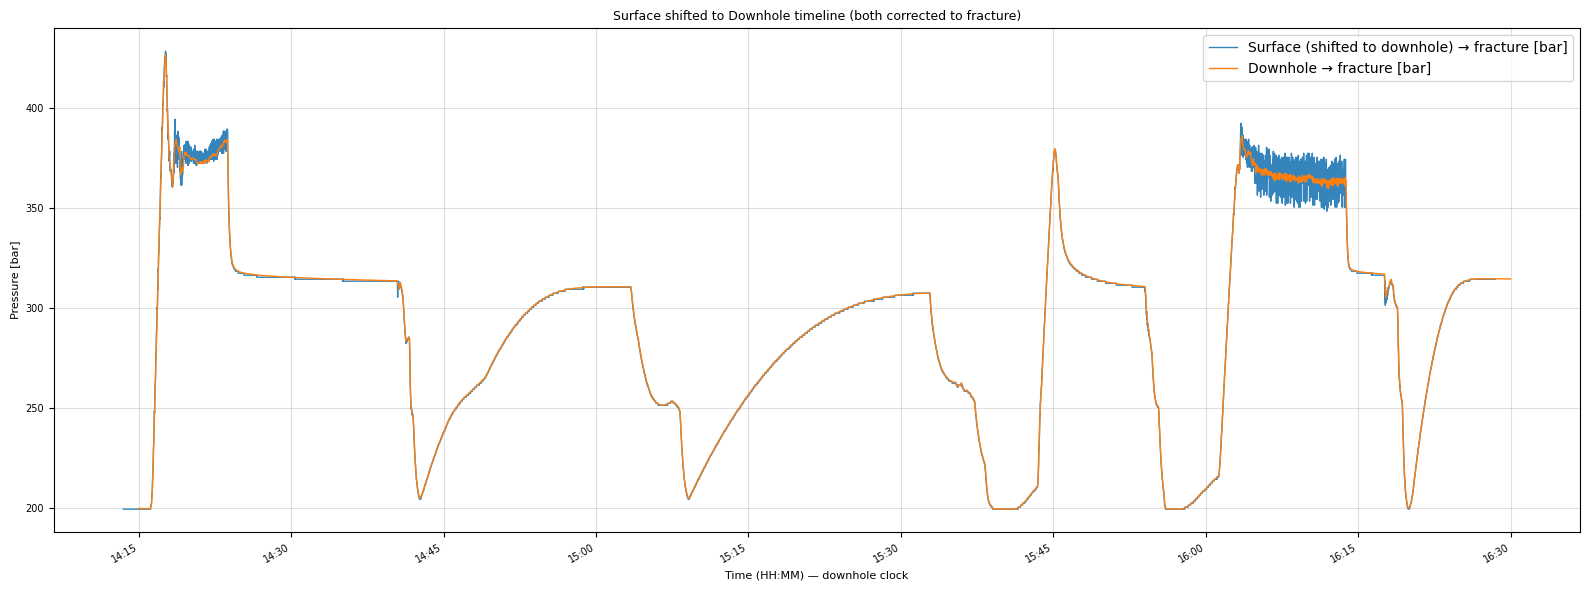

In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Local modules
import time_difference
import well_corrections
import closure_analysis
import plotting

# ----------------------------
# File paths (cross-platform)
# ----------------------------
base = Path("Data") / "Amstelland"

SURF_PATH = base / "NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt"
DOWN_PATH = base / "NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT"

CAP_S = 180            # analyze/plot max 3 minutes

# ----------------------------
# Helpers
# ----------------------------
def to_num(series):
    """
    Normalize numeric text: strip whitespace, remove NBSPs, comma→dot, coerce to float.
    Returns a pandas Series[float].
    """
    s = pd.Series(series, copy=False)
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce")
    s = s.astype(str).str.strip()
    s = s.str.replace('\u00A0', '', regex=False)   # NBSP
    s = s.str.replace(',', '.', regex=False)       # decimal comma -> dot
    s = s.replace({'': None})
    return pd.to_numeric(s, errors='coerce')

def get_or_nan(df, col):
    """Return numeric series for existing column or a NaN series matching df length."""
    if col in df.columns:
        return to_num(df[col])
    return pd.Series([np.nan] * len(df), index=df.index, dtype=float)


# ----------------------------
# Example usage
# ----------------------------
dfS = pd.read_csv(SURF_PATH, sep="\t", engine="python", on_bad_lines="skip")
dfD = pd.read_csv(DOWN_PATH, sep="\t", engine="python", on_bad_lines="skip")

print("Surface data file loaded:", SURF_PATH.resolve())
print("Downhole data file loaded:", DOWN_PATH.resolve())

# Ensure expected columns exist for downhole file
dfD.columns = ['Time', 'Delta Time', 'Pressure', 'Temperature', 'None', 'None2']

# Slice away headers/units lines typical of these exports
dfS = dfS.iloc[1:].reset_index(drop=True)
dfD = dfD.iloc[4:, :-2].reset_index(drop=True)  # drop last two 'None' cols

# ----------------------------
# Parse time columns
# ----------------------------
# Surface time format: %m:%d:%Y:%H:%M:%S
time_surface = pd.to_datetime(dfS['Time'], format='%m:%d:%Y:%H:%M:%S', errors='coerce')

# Downhole time format: %d-%m-%Y %H:%M:%S
time_downhole = pd.to_datetime(dfD['Time'].astype(str).str.strip(),
                               format='%d-%m-%Y %H:%M:%S', errors='coerce')

# ----------------------------
# Numeric columns (Surface)
# ----------------------------
pressure_S          = get_or_nan(dfS, 'Treating Pressure')
flowrate_S          = get_or_nan(dfS, 'Flow Rate') * 0.06 # l/min -> m³/hour
density_S           = get_or_nan(dfS, 'Density')
volume_S            = get_or_nan(dfS, 'Volume')
tot_volume_nrd_S    = get_or_nan(dfS, 'TOT vol nrd')
volume_nrd_S        = get_or_nan(dfS, 'NRD VOLUME')
return_volume_S     = get_or_nan(dfS, 'RETURN VOL')
totbalance_volume_S = get_or_nan(dfS, 'total bla')  # may not exist in some files
RDA_pressure_S      = get_or_nan(dfS, 'RDA2 IN1')

# ----------------------------
# Numeric columns (Downhole)
# ----------------------------
delta_time_D  = to_num(dfD['Delta Time'])
pressure_D    = to_num(dfD['Pressure']) * 0.0689476  # psi -> bar
temperature_D = to_num(dfD['Temperature'])

# ----------------------------
# Time windows
# ----------------------------
startS = pd.to_datetime("2023-12-10 15:15:00")
endS   = pd.to_datetime("2023-12-10 17:30:00")

startD = pd.to_datetime("2023-12-10 14:15:00")
endD   = pd.to_datetime("2023-12-10 16:30:00")

# ----------------------------
# Masks (NaN-safe)
# ----------------------------
maskS = (
    pressure_S.notna() &
    time_surface.notna() &
    (RDA_pressure_S.fillna(np.inf) <= 2000) &
    (time_surface >= startS) & (time_surface <= endS)
)

time_S               = time_surface[maskS]
pressure_S           = pressure_S[maskS]
flowrate_S           = flowrate_S[maskS]
density_S            = density_S[maskS]
volume_S             = volume_S[maskS]
tot_volume_nrd_S     = tot_volume_nrd_S[maskS]
volume_nrd_S         = volume_nrd_S[maskS]
return_volume_S      = return_volume_S[maskS]
totbalance_volume_S  = totbalance_volume_S[maskS]
RDA_pressure_S       = RDA_pressure_S[maskS]

print('surface time min/max:', (time_surface.min(), time_surface.max()))

maskD = (
    time_downhole.notna() &
    pressure_D.notna() &
    temperature_D.notna() &
    (time_downhole >= startD) & (time_downhole <= endD)
)

time_D        = time_downhole[maskD]
delta_time_D  = delta_time_D[maskD]
pressure_D    = pressure_D[maskD]
temperature_D = temperature_D[maskD]

print('downhole time min/max:', (time_downhole.min(), time_downhole.max()))

# ----------------------------
# Surface panels
# ----------------------------
fig1, axs1 = plotting.plot_surface_panels(
    time_S, pressure_S, flowrate_S, density_S, volume_S,
    tot_volume_nrd_S, return_volume_S, totbalance_volume_S, RDA_pressure_S,
    figsize=(22, 8), markersize=0.2, linewidth=1.0, tick_labelsize=7, title_labelsize=6
)

# ----------------------------
# Triple-axis (surface subset)
# ----------------------------
fig2, (ax1, ax2, ax3) = plotting.plot_triple_axis(
    time_S, pressure_S, flowrate_S, return_volume_S,
    start=startS, end=endS, figsize=(16, 6)
)

# ----------------------------
# Downhole P/T plot
# ----------------------------
fig3, (ax4, ax5) = plotting.plot_downhole_pt(time_D, pressure_D, temperature_D, figsize=(16, 6))

# ----------------------------
# Depths & lag estimation
# ----------------------------
# Example MD/TVD arrays; replace with real values
MD = np.array([1364, 1383, 1383.3], dtype=float)
TVD = np.array([1363.18, np.nan, 1382.31], dtype=float)  # NaN = missing value
TVD_fracture_m = 1866.50
gauge_index    = 1  # index of the downhole gauge in the MD/TVD arrays

# NOTE: we use the (MD, TVD, gauge_index, TVD_fracture_m) signature per the fixed helper
TVD_interp, TVD_gauge_m, delta_tvd_m = well_corrections.estimate_lag(MD, TVD, gauge_index, TVD_fracture_m)

# Estimate delay (surface vs downhole)
try:
    lag_s, grid_step = time_difference.estimate_delay_seconds_robust(
        time_S, pressure_S,
        time_D, pressure_D,
        max_lag_s=4*3600,    # 4 hours
        detrend_window_s=120
    )
except Exception as e:
    print("Delay estimation failed; defaulting lag_s=0. Reason:", e)
    lag_s = 0.0
print(f"Estimated delay: {float(lag_s)/3600:.2f} h")
# To align SURFACE to DOWNHOLE we shift SURFACE by **-lag_s**.

# ----------------------------
# Hydrostatic corrections to fracture depth
# ----------------------------
# Surface pressure corrected to fracture (if surface sensor is at TVD≈0, ΔTVD≈TVD_fracture_m)
p_surface_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_S,      # SURFACE treating pressure [bar]
    time_gauge=time_S,
    rho_surface=density_S,   # surface density series
    time_surface=time_S,
    delta_tvd_m=TVD_fracture_m,  # surface(0) -> fracture
    out_units='bar',
    lag_s=None
)

# Downhole gauge corrected to fracture
p_downhole_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_D,      # DOWNHOLE gauge [bar]
    time_gauge=time_D,
    rho_surface=density_S,   # use surface density aligned to DH via lag_s
    time_surface=time_S,
    delta_tvd_m=delta_tvd_m, # TVD_fracture - TVD_gauge
    out_units='bar',
    lag_s=lag_s
)

# ----------------------------
# Build aligned timelines (DOWNHOLE clock)
# ----------------------------
surface_dt_orig  = pd.to_datetime(time_S)
downhole_dt_orig = pd.to_datetime(time_D)

# Shift SURFACE timestamps by **-lag_s** to align onto DOWNHOLE clock
surface_dt_aligned_to_dh = surface_dt_orig - pd.to_timedelta(float(lag_s), unit='s')

y_surface  = pd.Series(p_surface_corr, copy=False).astype(float).to_numpy()
y_downhole = pd.Series(p_downhole_corr, copy=False).astype(float).to_numpy()

# Plot alignment (datetime)
figA, axA = plotting.plot_alignment(surface_dt_aligned_to_dh, y_surface, downhole_dt_orig, y_downhole, figsize=(16, 6))


Auto-detected shut-in (surface clock): 2023-12-10 17:15:24
Shut-in used for DH analysis (downhole clock): 2023-12-10 16:13:53
Falloff samples (capped): 61; duration = 178.0 s
FCP (√t min)           : 330.25 bar at t ≈ 4 s
FCP (Bourdet min)      : 330.25 bar at t ≈ 7 s
FCP (√t intersection)  : 319.12 bar at t ≈ 17 s
FCP (G intersection)   : 318.45 bar at t ≈ 16 s


Text(0.5, 1.0, 'G-function intersection (t_p ≈ 633 s)')

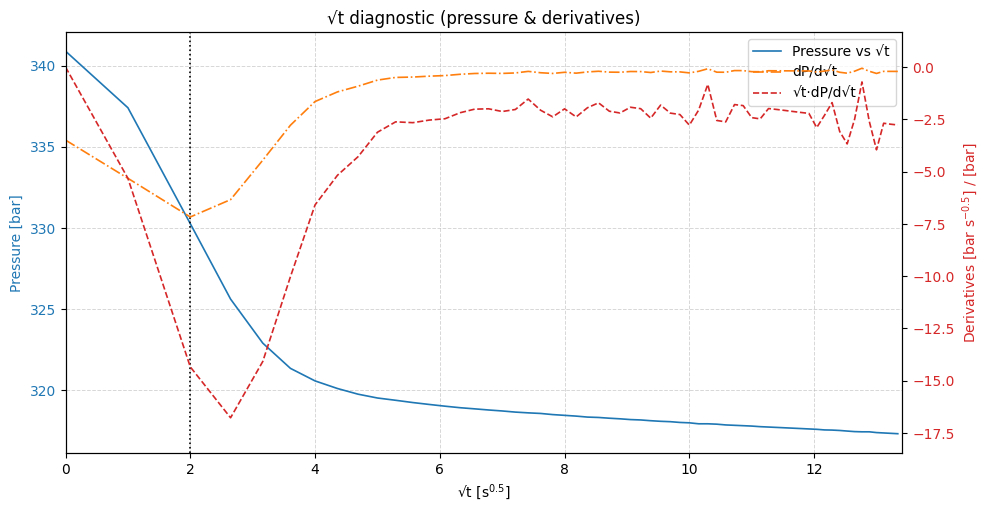

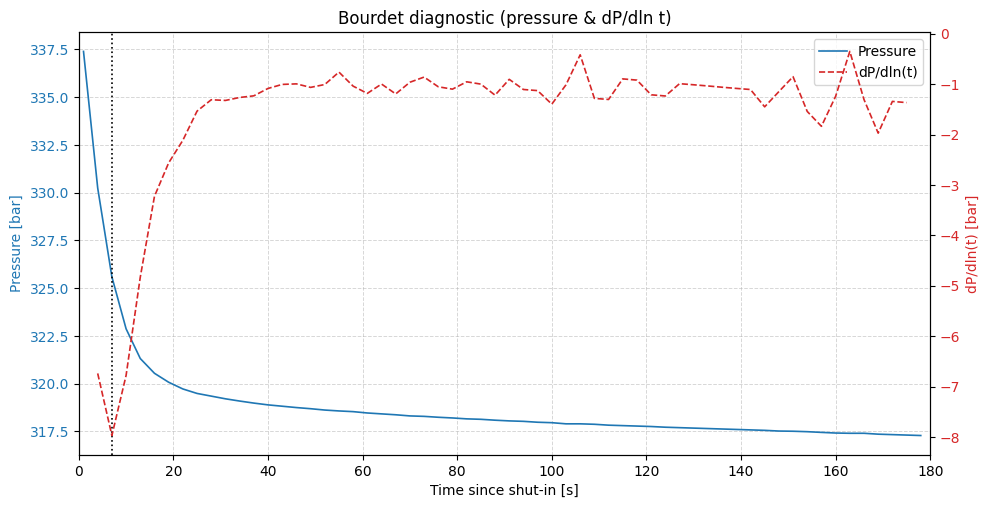

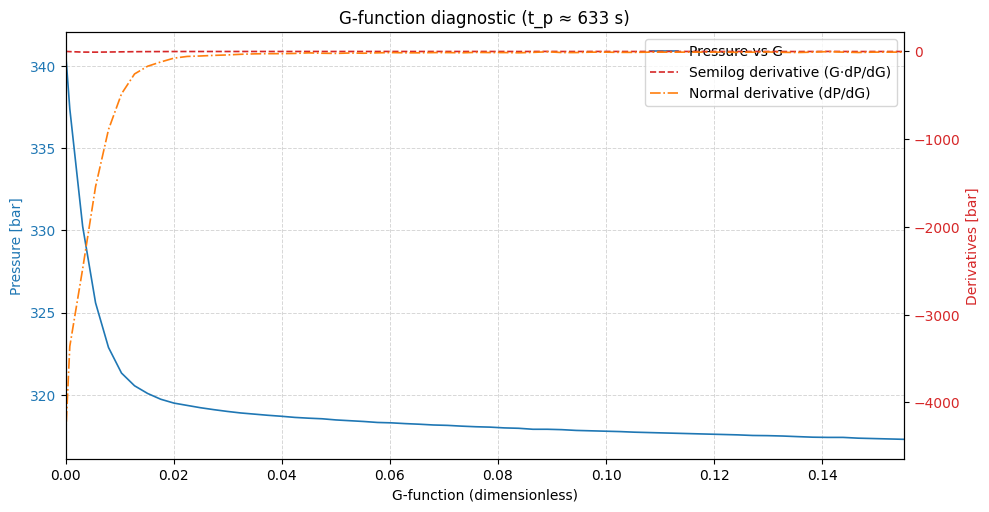

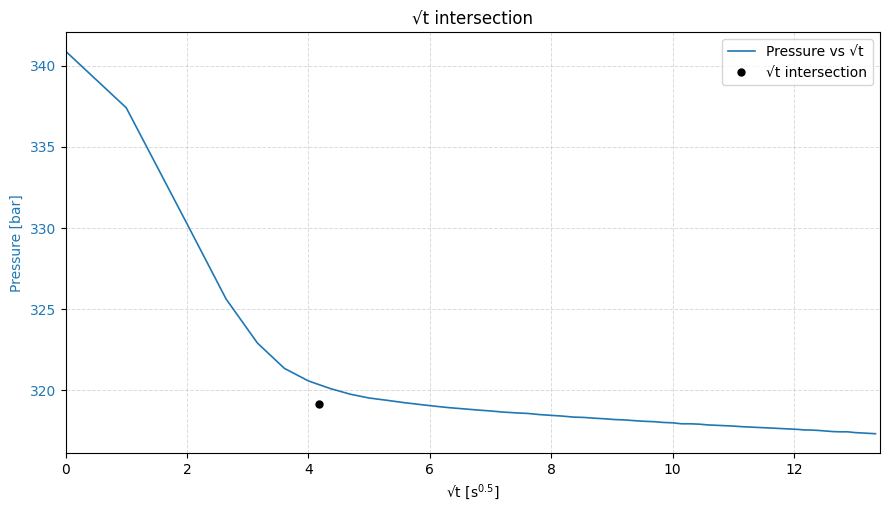

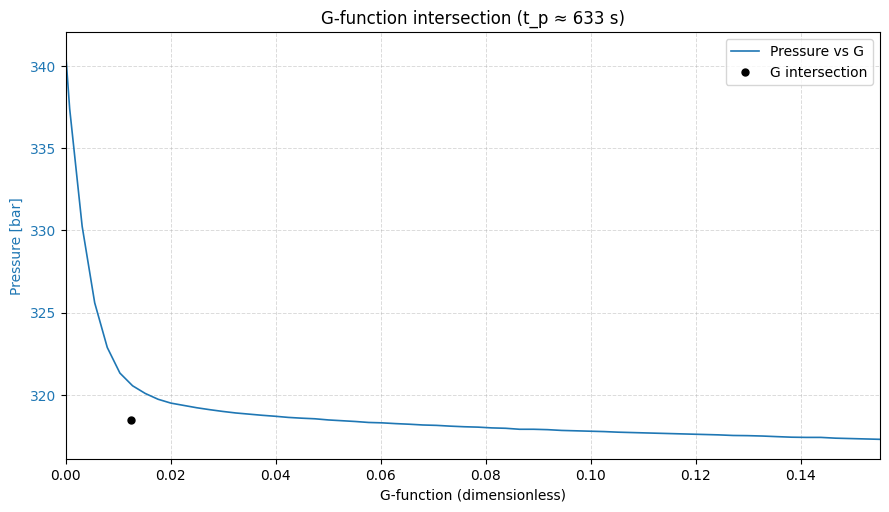

In [2]:
# ----------------------------
# Closure analysis (DOWNHOLE time basis) — single cycle
# ----------------------------
# 1) Auto shut-in detection on SURFACE clock
t_shut_in_auto_surface = closure_analysis.find_shut_in_time_from_flow(
    time_S, flowrate_S, threshold=0.1, min_hold_s=10
)
print("Auto-detected shut-in (surface clock):", t_shut_in_auto_surface)

# Fallback if not found
t_shut_in_surface = (
    t_shut_in_auto_surface if t_shut_in_auto_surface is not None
    else pd.to_datetime(time_S.iloc[-1])
)

# 2) Convert shut-in to DOWNHOLE clock by shifting **-lag_s**
t_shut_in_downhole = t_shut_in_surface - pd.to_timedelta(float(lag_s), unit='s')
print("Shut-in used for DH analysis (downhole clock):", t_shut_in_downhole)

# 3) Build downhole falloff (DH clock) and hard-cap to 180 s for analysis
ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_downhole_corr, t_shut_in_downhole)
if len(ts_dh) == 0:
    raise RuntimeError("No downhole samples at/after shut-in.")
cap_s = 180.0
keep = (ts_dh <= cap_s)
ts_dh, p_dh = ts_dh[keep], p_dh[keep]
print(f"Falloff samples (capped): {len(ts_dh)}; duration = {ts_dh[-1]:.1f} s")

# Helper: estimate last pump-start (surface clock) before shut-in
def _last_pump_start_before_shutin(time_s, q_m3h, t_shut_s, q_low=None, q_high=None):
    t = pd.to_datetime(pd.Series(time_s))
    q = pd.Series(q_m3h, dtype=float)

    # Adaptive hysteresis if not given
    if q_high is None or q_low is None:
        qpos = q[q > 0].dropna()
        if len(qpos):
            q_high = max(0.3, qpos.quantile(0.15)) if q_high is None else q_high
            q_low  = max(0.1, qpos.quantile(0.02)) if q_low  is None else q_low
        else:
            q_high = 0.3 if q_high is None else q_high
            q_low  = 0.1 if q_low  is None else q_low

    m = (t < t_shut_s) & q.notna()
    t, q = t[m].reset_index(drop=True), q[m].reset_index(drop=True)
    if len(t) < 2:
        return None

    state = 'idle'
    last_start = None
    for i in range(len(t)):
        if state == 'idle' and q.iloc[i] >= q_high:
            last_start = t.iloc[i]
            state = 'pumping'
        elif state == 'pumping' and q.iloc[i] <= q_low:
            state = 'idle'
    return last_start

# 4) Estimate pumping time tp_s for G-function (surface clock ⇒ seconds)
t_pump_start_surface = _last_pump_start_before_shutin(time_S, flowrate_S, t_shut_in_surface)
if t_pump_start_surface is not None:
    tp_s = (t_shut_in_surface - t_pump_start_surface).total_seconds()
else:
    tp_s = 0.0
# Safe fallback to avoid tp=0
if not np.isfinite(tp_s) or tp_s <= 0:
    tp_s = max(1.0, float(ts_dh[0]))

# ----------------------------
# √t diagnostic (pressure + normal & semilog derivatives)
# ----------------------------
x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(ts_dh, p_dh, max_t_s=cap_s)
i_srt = closure_analysis.suggest_closure_from_srt(
    x_sqrt, p_srt, dpdx, min_t_s=0, max_t_s=cap_s
)

figSRT, (ax_srt_left, ax_srt_right) = plotting.plot_srt(
    x_sqrt, p_srt, dpdx, i_cl=i_srt, cap_s=cap_s
)
ax_srt_left.set_title("√t diagnostic (pressure & derivatives)")

if i_srt is not None:
    p_closure_srt = p_srt[i_srt]
    print(f"FCP (√t min)           : {p_closure_srt:.2f} bar at t ≈ {x_sqrt[i_srt]**2:.0f} s")

# ----------------------------
# Bourdet diagnostic (pressure + dP/dln t)
# ----------------------------
t_log, dP_dlogt = closure_analysis.bourdet_derivative(ts_dh, p_dh, smooth_win=None, max_t_s=cap_s)
i_brd = closure_analysis.suggest_closure_from_bourdet(
    t_log, dP_dlogt, min_t_s=0, max_t_s=cap_s
)

figBRD, axBRD = plotting.plot_bourdet(
    t_log, dP_dlogt,
    p=p_dh,        # plot pressure on left axis
    p_times=ts_dh, # interpolate onto t_log if needed
    i_cl=i_brd,
    cap_s=cap_s
)
axBRD.set_title("Bourdet diagnostic (pressure & dP/dln t)")

if i_brd is not None:
    print(f"FCP (Bourdet min)      : {p_dh[i_brd]:.2f} bar at t ≈ {t_log[i_brd]:.0f} s")

# ----------------------------
# G-function diagnostic (pressure + semilog & normal derivatives)
# ----------------------------
figG, axG = plotting.plot_gfunction(
    ts_seconds=ts_dh,
    p=p_dh,
    tp_seconds=tp_s,
    p_times=ts_dh,
    i_cl=None,
    cap_s=cap_s
)
axG.set_title(f"G-function diagnostic (t_p ≈ {tp_s:.0f} s)")

# ----------------------------
# Intersection methods (√t & G)
# ----------------------------
res_srt = closure_analysis.fcp_by_sqrt_intersection(
    ts_dh, p_dh, max_t_s=cap_s, min_left=8, min_right=8
)
if res_srt.get('ok'):
    print(f"FCP (√t intersection)  : {res_srt['closure_pressure_bar']:.2f} bar "
          f"at t ≈ {res_srt['closure_time_s']:.0f} s")

res_g = closure_analysis.fcp_by_g_intersection(
    ts_dh, p_dh, tp_seconds=tp_s, max_t_s=cap_s, min_left=8, min_right=8
)
if res_g.get('ok'):
    print(f"FCP (G intersection)   : {res_g['closure_pressure_bar']:.2f} bar "
          f"at t ≈ {res_g['closure_time_s']:.0f} s")

# Plots for the intersection fits
fig_srt_int, ax_srt_int = plotting.plot_srt_intersection(
    ts_seconds=ts_dh, p=p_dh, res_srt=res_srt, cap_s=cap_s
)
ax_srt_int.set_title("√t intersection")

fig_g_int, ax_g_int = plotting.plot_g_intersection(
    ts_seconds=ts_dh, p=p_dh, res_g=res_g, tp_seconds=tp_s, cap_s=cap_s
)
ax_g_int.set_title(f"G-function intersection (t_p ≈ {tp_s:.0f} s)")

In [3]:
# ----------------------------
# MULTI-CYCLE: detect all pump-in → shut-in cycles (surface clock)
# and cut each falloff at (pump restart | flow-back start | end of data)
# ----------------------------
q_low, q_high = closure_analysis.suggest_flow_thresholds(flowrate_S)
cycles = closure_analysis.detect_pump_cycles(
    time_S=time_S,
    q_m3h=flowrate_S,
    return_vol_S=return_volume_S,
    q_low=q_low, q_high=q_high,
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2
)

cycles = closure_analysis.detect_pump_cycles(
    time_S=time_S,
    q_m3h=flowrate_S,
    return_vol_S=return_volume_S,   # pass None if not available
    q_low=0.1, q_high=0.3,
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2
)
print(f"Detected {len(cycles)} cycles.")

df_cycles = closure_analysis.analyze_all_shutins(
    cycles,
    time_S=time_S, flowrate_S=flowrate_S, return_volume_S=return_volume_S,
    time_D=time_D, p_downhole_corr=p_downhole_corr,
    lag_s=lag_s,
    min_falloff_s=10,
    min_t_s_for_pick=0,
    max_analysis_s=180,
    pick_from="bourdet"   # <--- use Bourdet min
)

print("\nSummary table:")
print(df_cycles)

out_path = Path("per_cycle_closure.csv")
df_cycles.to_csv(out_path, index=False)
print(f"Saved per-cycle results to: {out_path.resolve()}")

Detected 3 cycles.

Summary table:
   cycle t_pump_start_surface   t_shut_in_surface       t_end_surface  \
0      1  2023-12-10 15:17:39 2023-12-10 15:25:20 2023-12-10 16:45:00   
1      2  2023-12-10 16:45:00 2023-12-10 16:47:02 2023-12-10 17:02:53   
2      3  2023-12-10 17:02:53 2023-12-10 17:15:24 2023-12-10 17:30:00   

  ended_by  usable  closure_time_s  closure_pressure_bar  analysis_window_s  \
0  restart    True            11.0            337.601646              180.0   
1  restart    True            23.0            336.811093              180.0   
2      end    True             7.0            330.248109              180.0   

    picker  
0  bourdet  
1  bourdet  
2  bourdet  
Saved per-cycle results to: /Users/william/Desktop/Thesis-AES/per_cycle_closure.csv



Per-cycle closure analysis (Bourdet & G-function within 0–180 s):
  Cycle 1: FCP (Bourdet) ≈ 337.60 bar at t ≈ 11 s (ended by restart, window 180s)
            FCP (√t)      ≈ 344.25 bar at t ≈ 5 s
            FCP (G-func)  ≈ 332.69 bar at t ≈ 11 s (tp=461s)
  Cycle 2: FCP (Bourdet) ≈ 336.81 bar at t ≈ 23 s (ended by restart, window 180s)
            FCP (√t)      ≈ 348.13 bar at t ≈ 8 s
            FCP (G-func)  ≈ 338.95 bar at t ≈ 17 s (tp=122s)
  Cycle 3: FCP (Bourdet) ≈ 330.25 bar at t ≈ 7 s (ended by end, window 180s)
            FCP (√t)      ≈ 330.25 bar at t ≈ 4 s
            FCP (G-func)  ≈ 325.59 bar at t ≈ 7 s (tp=751s)


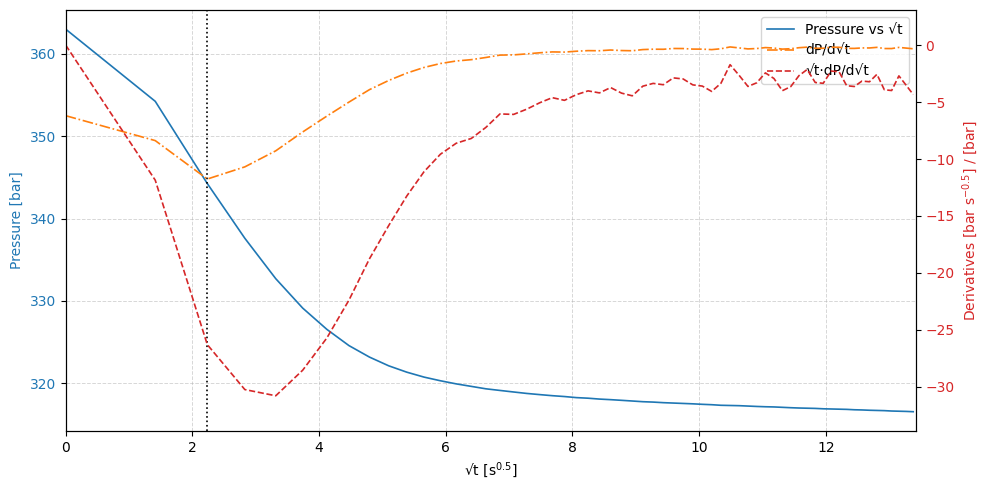

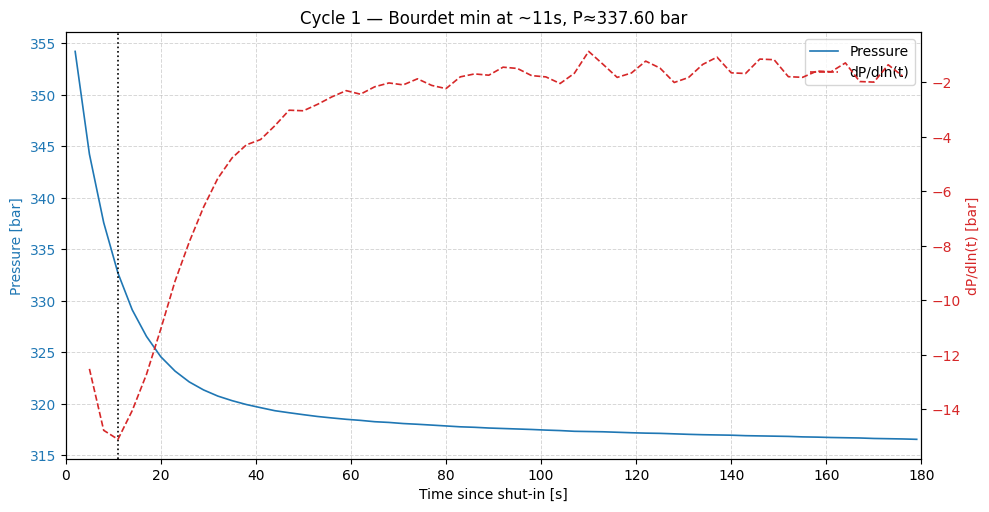

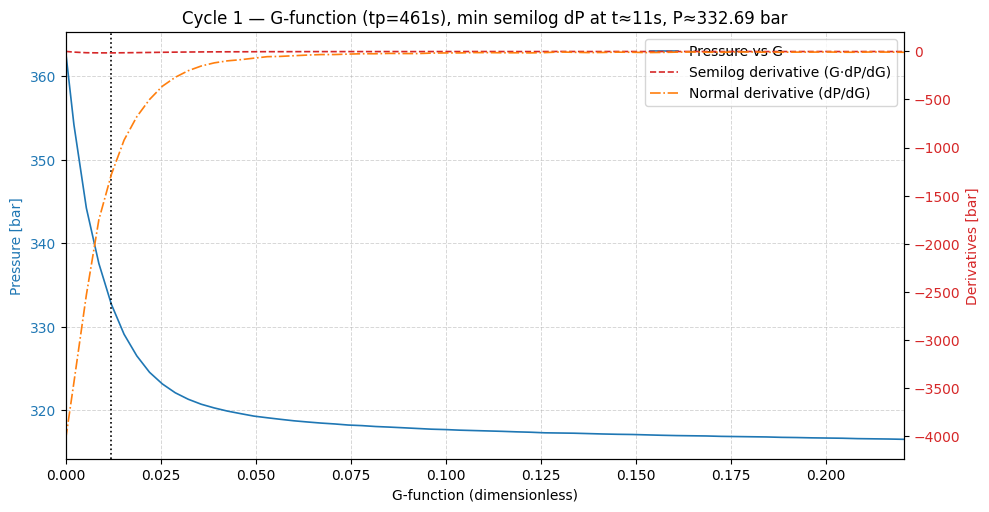

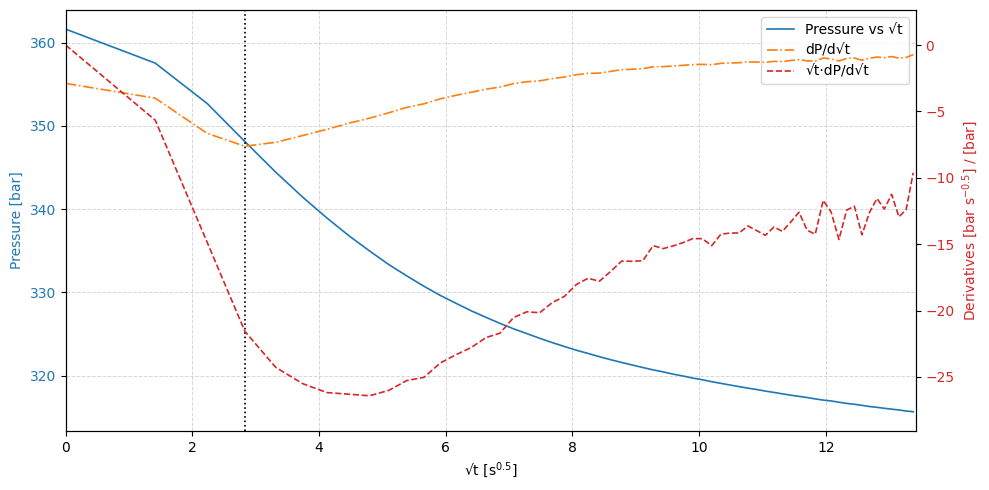

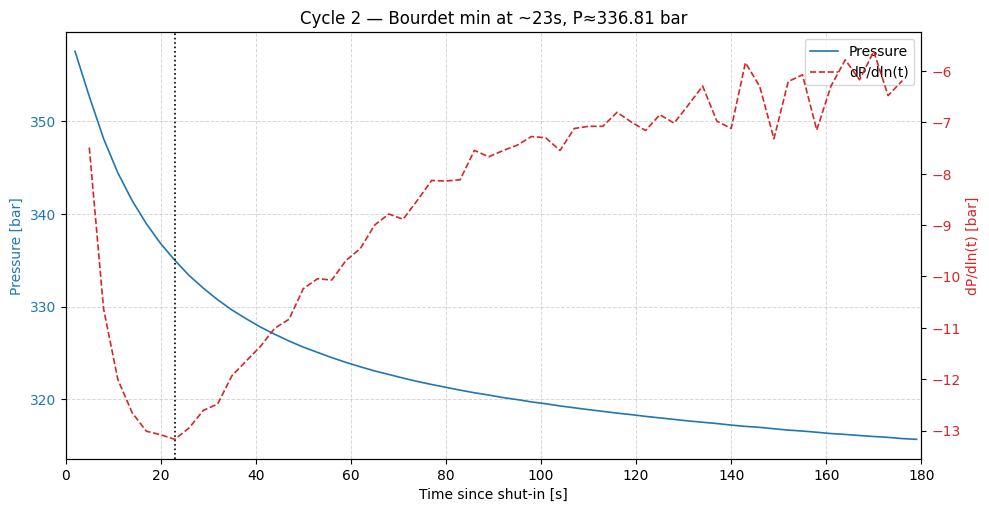

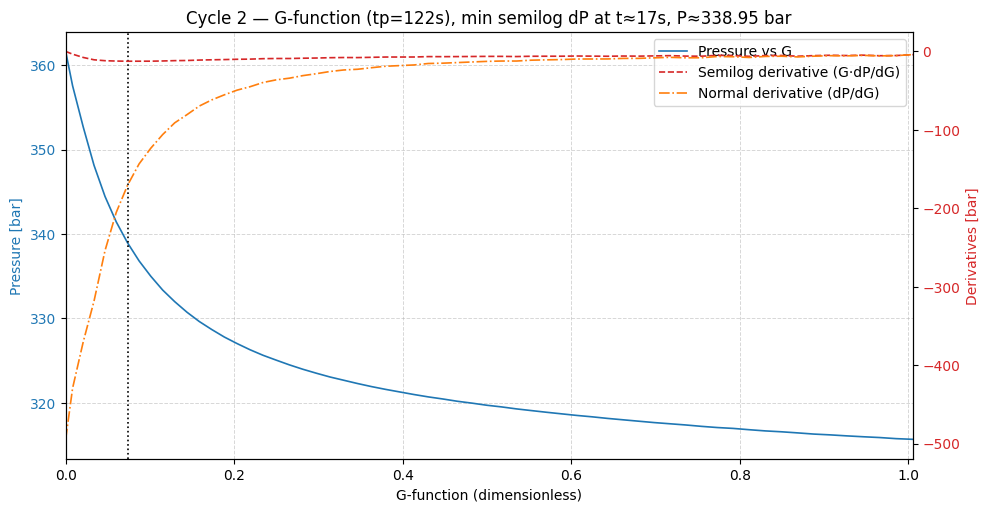

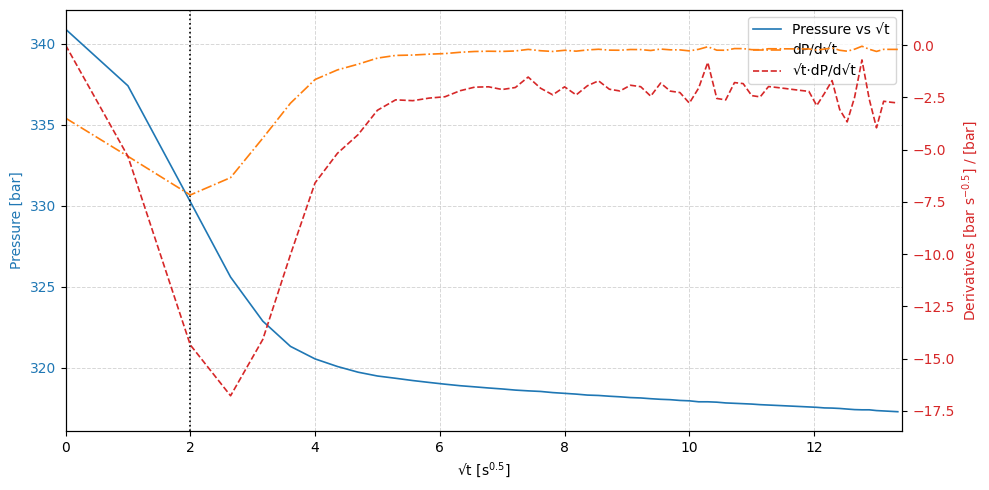

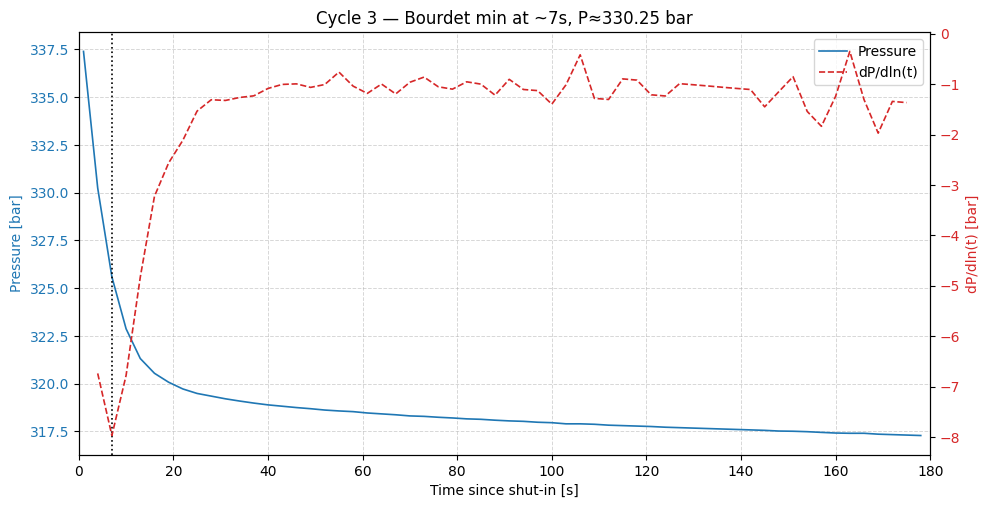

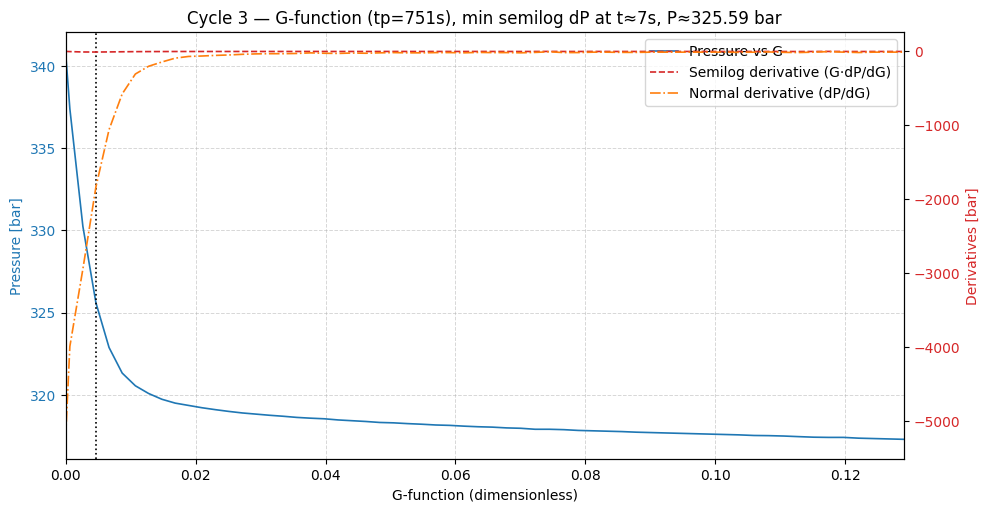

In [4]:
# ----------------------------
# PER-CYCLE diagnostics & plots (for every detected cycle)
# ----------------------------
MIN_T_S_FOR_PICK = 0   # e.g., set to 90 to ignore the first 90 s

if len(cycles) == 0:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis (Bourdet & G-function within 0–180 s):")
    for i, cyc in enumerate(cycles, 1):
        # Convert cycle window to DOWNHOLE clock
        t_shut_D = cyc['t_shut_in_surface'] - pd.to_timedelta(float(lag_s), unit='s')
        t_end_D  = cyc['t_end_surface']      - pd.to_timedelta(float(lag_s), unit='s')

        # Build + cap falloff series
        ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_downhole_corr, t_shut_D)
        t_end_rel   = (pd.to_datetime(t_end_D) - pd.to_datetime(t_shut_D)).total_seconds()
        t_hard_cap  = min(float(t_end_rel), float(CAP_S))
        keep        = (ts_dh <= t_hard_cap)
        ts_dh, p_dh = ts_dh[keep], p_dh[keep]

        # Require some usable falloff
        if len(ts_dh) < 3 or (ts_dh[-1] if len(ts_dh) else 0) < 120:
            print(f"  Cycle {i}: skipped (too short falloff: {ts_dh[-1] if len(ts_dh) else 0:.0f}s).")
            continue

        # --- Bourdet derivative pick (global minimum) ---
        t_log, dP_dlogt = closure_analysis.bourdet_derivative(
            ts_dh, p_dh, smooth_win=None, max_t_s=CAP_S
        )
        i_brd = closure_analysis.suggest_closure_from_bourdet(
            t_log, dP_dlogt, min_t_s=MIN_T_S_FOR_PICK, max_t_s=CAP_S
        )

        # --- √t diagnostic (QC) ---
        x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(
            ts_dh, p_dh, max_t_s=CAP_S
        )
        i_srt = closure_analysis.suggest_closure_from_srt(
            x_sqrt, p_srt, dpdx, min_t_s=MIN_T_S_FOR_PICK, max_t_s=CAP_S
        )

        # --- G-function diagnostic (Barree/Nolte) ---
        # Approx pumping time per cycle: tp = shut-in - pump-start (surface clock)
        try:
            tp_s = (cyc['t_shut_in_surface'] - cyc['t_pump_start_surface']).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, ts_dh[0] if len(ts_dh) else 1.0)  # safe fallback

        # For a G-based pick: global min of semilog derivative within window
        G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)
        semilog_dP = closure_analysis.semilog_derivative(G, p_dh)
        i_g = None
        if len(G) >= 3 and np.isfinite(semilog_dP).any():
            mwin = (
                (ts_dh >= float(MIN_T_S_FOR_PICK)) &
                (ts_dh <= float(CAP_S)) &
                np.isfinite(semilog_dP)
            )
            if mwin.any():
                idx = np.where(mwin)[0]
                i_g = idx[np.nanargmin(semilog_dP[idx])]

        # --- Plot √t (pressure on left; dP/d√t & √t·dP/d√t on right), with marker ---
        figSRT, (ax_left_srt, ax_right_srt) = plotting.plot_srt(
            x_sqrt, p_srt, dpdx, i_cl=i_srt, cap_s=CAP_S
        )

        # --- Plot Bourdet (pressure on left; dP/dln t on right), with marker ---
        figBRD, axBRD = plotting.plot_bourdet(
            t_log, dP_dlogt,
            p=p_dh,           # pressure samples
            p_times=ts_dh,    # their time base (sec since shut-in)
            i_cl=i_brd,
            cap_s=CAP_S
        )
        if i_brd is not None:
            axBRD.set_title(f"Cycle {i} — Bourdet min at ~{t_log[i_brd]:.0f}s, P≈{p_dh[i_brd]:.2f} bar")
        else:
            axBRD.set_title(f"Cycle {i} — no Bourdet min in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s")

        # --- Plot G-function (pressure on left; semilog & normal derivs on right), with marker ---
        figG, axG = plotting.plot_gfunction(
            ts_seconds=ts_dh,
            p=p_dh,
            tp_seconds=tp_s,
            p_times=ts_dh,
            i_cl=i_g,
            cap_s=CAP_S
        )
        if i_g is not None:
            axG.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), min semilog dP at t≈{ts_dh[i_g]:.0f}s, "
                f"P≈{p_dh[i_g]:.2f} bar"
            )
        else:
            axG.set_title(f"Cycle {i} — G-function (tp={tp_s:.0f}s), no min in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s")

    
            
        # Print the results
        if i_brd is not None:
            print(f"  Cycle {i}: FCP (Bourdet) ≈ {p_dh[i_brd]:.2f} bar at t ≈ {t_log[i_brd]:.0f} s "
                  f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)")
        else:
            print(f"  Cycle {i}: no Bourdet minimum found in [{MIN_T_S_FOR_PICK}, {CAP_S}] s.")

        if i_srt is not None:
            print(f"            FCP (√t)      ≈ {p_srt[i_srt]:.2f} bar at t ≈ {x_sqrt[i_srt]**2:.0f} s")

        if i_g is not None:
            print(f"            FCP (G-func)  ≈ {p_dh[i_g]:.2f} bar at t ≈ {ts_dh[i_g]:.0f} s "
                  f"(tp={tp_s:.0f}s)")